In [1]:
from src.DataFolder import DataFolder
from src.NeuralSignal import NeuralSignal
from src.runtime_logger import logger_setup

import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_path = "/home/miranjo/phasic_tonic/data/processed"
config_path = "/home/miranjo/phasic_tonic/configs/test.yaml"

## Setup

### Load the config file

In [2]:
with open(config_path, 'r') as f:
    args = yaml.safe_load(f)

fs                  = args.pop("fs")
f_theta             = (args.pop("f_theta_lower"), args.pop("f_theta_upper"))
f_lowpass           = args.pop("f_lowpass")
lowpass_length      = args.pop("lowpass_length")
bandpass_length     = args.pop("bandpass_length")
threshold_bycycle   = args.pop("threshold_bycycle")
threshold_episode   = args.pop("threshold_episode")

# Start logger
logger_setup()

<Logger runtime (DEBUG)>

### Load the dataset

In [3]:
remFolder = DataFolder(data_path)

### Utilities

In [4]:
def get_duration(episode):
    return episode[1] - episode[0]

# Analysis

## Dataset

In [5]:
phasic_HC = []
phasic_OC = []
tonic_HC = []
tonic_OC = []

for sample in remFolder:
    lfpREMs = sample["data"]
    metadata = sample["metadata"]
    
    #if (metadata["treatment"] == "TreatmentPositive"): # Skip CBD treatment records
    #    continue

    if metadata["condition"] == "HC":
        homecage = True
    else:
        homecage = False
    
    for lfpREM in lfpREMs:
        if(len(lfpREM) < 2500):
            break #Skip when the duration is less than a second
         
        theta = NeuralSignal(lfpREM, fs)
        theta.filter('lowpass', f_range=f_lowpass, n_seconds=lowpass_length)
        theta.segment(f_range=f_theta, threshold_episode=threshold_episode, threshold_bycycle=threshold_bycycle)

        for phasic in theta.phasic:
            if homecage:
                phasic_HC.append(get_duration(phasic))
            else:
                phasic_OC.append(get_duration(phasic))

        for tonic in theta.tonic:
            if homecage:
                tonic_HC.append(get_duration(tonic))
            else:
                tonic_OC.append(get_duration(tonic))

In [6]:
phasic = pd.concat([
    pd.DataFrame(data={"Duration (s)" : np.array(phasic_HC)/2500, "Homecage" : np.ones(len(phasic_HC), dtype=np.int8)}),
    pd.DataFrame(data={"Duration (s)" : np.array(phasic_OC)/2500, "Homecage" : np.zeros(len(phasic_OC), dtype=np.int8)})],
    axis=0)

tonic = pd.concat([
    pd.DataFrame(data={"Duration (s)" : np.array(tonic_HC)/2500, "Homecage" : np.ones(len(tonic_HC), dtype=np.int8)}),
    pd.DataFrame(data={"Duration (s)" : np.array(tonic_OC)/2500, "Homecage" : np.zeros(len(tonic_OC), dtype=np.int8)})],
    axis=0)

Text(0, 0.5, 'Duration (s)')

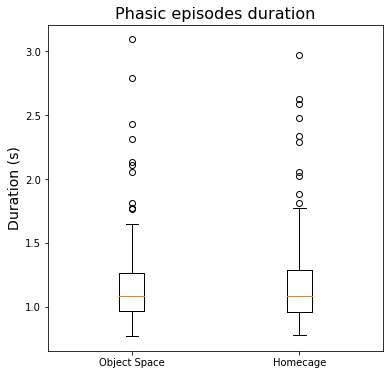

In [12]:
plt.figure(figsize=(6,6))
plt.boxplot([phasic[phasic["Homecage"] == 0]["Duration (s)"],
             phasic[phasic["Homecage"] == 1]["Duration (s)"]],
             labels=["Object Space", "Homecage"])
plt.title("Phasic episodes duration", fontsize=16)
plt.ylabel("Duration (s)", fontsize=14)

Text(0, 0.5, 'Duration (s)')

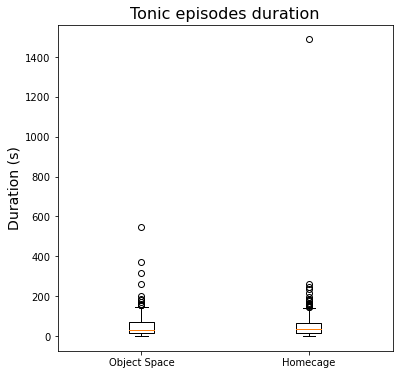

In [13]:
plt.figure(figsize=(6,6))
plt.boxplot([tonic[tonic["Homecage"] == 0]["Duration (s)"],
             tonic[tonic["Homecage"] == 1]["Duration (s)"]],
             labels=["Object Space", "Homecage"])
plt.title("Tonic episodes duration", fontsize=16)
plt.ylabel("Duration (s)", fontsize=14)

Text(0, 0.5, 'Duration (s)')

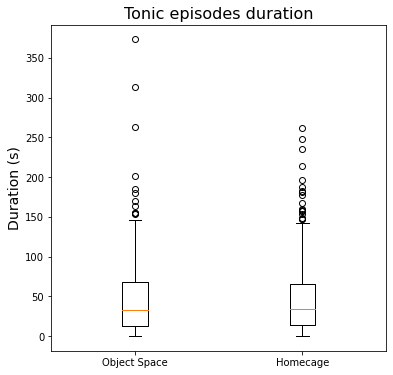

In [16]:
tonic_r = tonic[tonic["Duration (s)"] < 500.0]
plt.figure(figsize=(6,6))

plt.boxplot([tonic_r[tonic_r["Homecage"] == 0]["Duration (s)"],
             tonic_r[tonic_r["Homecage"] == 1]["Duration (s)"]],
             labels=["Object Space", "Homecage"])

plt.title("Tonic episodes duration", fontsize=16)
plt.ylabel("Duration (s)", fontsize=14)

In [20]:
phasic.to_excel("phasic_episodic_duration.xlsx")
tonic.to_excel("tonic_episodic_duration.xlsx")